In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [2]:
stir = pd.read_csv('var_ru/ru_stir_m.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [5]:
stir.index = stir['TIME']

In [6]:
stir = stir[['Value']].copy()

In [7]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [8]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [9]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [10]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [11]:
inf_l = inf_l[:-8]

In [12]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [13]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [14]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%m') + relativedelta(months=i))

In [15]:
infr = pd.DataFrame([inf_l, date_list], index=['Value', 'date']).T.iloc[:-4, :]

#### Unemployment

In [16]:
umpr = pd.read_csv('var_ru/ru_unemployment.csv')

In [17]:
umpr = umpr[['date', 'fact']].sort_index(axis=0, ascending=False).reset_index(drop=True).copy()

In [18]:
ump_l = umpr['fact'].tolist()[:-1]

In [19]:
for i in range(len(ump_l)):
    ump_l[i] = ump_l[i].replace(',', '.').replace('%', '')
    ump_l[i] = float(ump_l[i])

In [20]:
date_list = []
for i in range(len(ump_l)):
    date_list.append(datetime.strptime('1992-11', '%Y-%m') + relativedelta(months=i))

In [21]:
umpr = pd.DataFrame([ump_l[:-1], date_list], index=['Value', 'date']).T

#### Make full df

In [22]:
umpr.index = umpr['date']
umpr = umpr[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [23]:
df_var_t = pd.concat([umpr, stir, infr], axis=1).dropna()
df_var_t.columns = ['umpr', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                  -1.934407
p-value                          0.316052
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (5%)             -2.874531
Critical Value (1%)             -3.459885
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            1.293213
p-value                   0.010000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


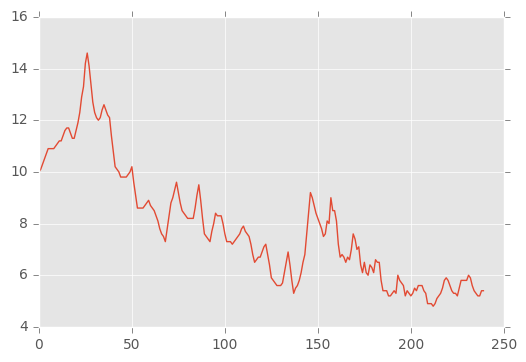

In [24]:
test_stationarity(df_var_t['umpr'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.360835
p-value                          0.153097
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (5%)             -2.874531
Critical Value (1%)             -3.459885
Critical Value (10%)            -2.573694
dtype: float64


Results of KPSS Test:
Test Statistic            0.669004
p-value                   0.016363
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


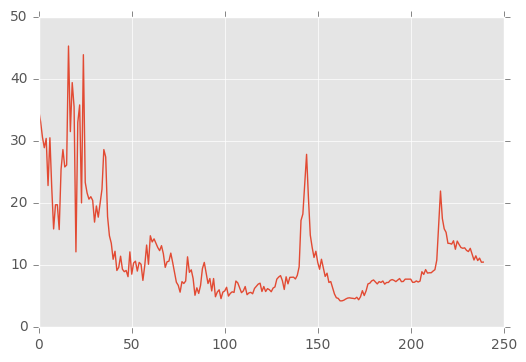

In [25]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                -5.799629e+00
p-value                        4.663731e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (5%)           -2.873814e+00
Critical Value (1%)           -3.458247e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.527277
p-value                   0.035523
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


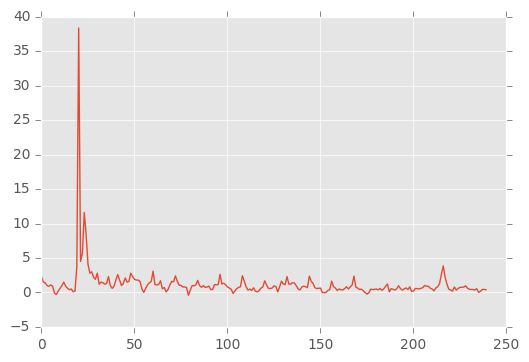

In [26]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                  -3.425170
p-value                          0.010130
#Lags Used                      15.000000
Number of Observations Used    223.000000
Critical Value (5%)             -2.874590
Critical Value (1%)             -3.460019
Critical Value (10%)            -2.573725
dtype: float64


Results of KPSS Test:
Test Statistic            0.051855
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


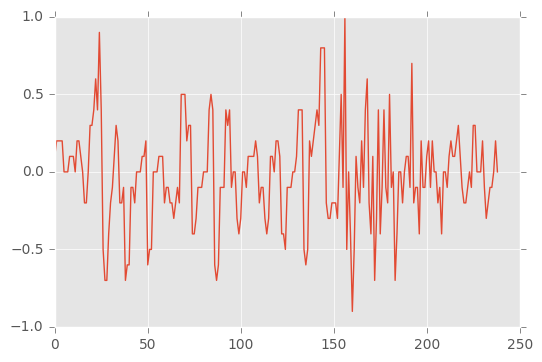

In [27]:
test_stationarity(diff_series(df_var_t['umpr']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.087974
p-value                          0.000015
#Lags Used                      11.000000
Number of Observations Used    227.000000
Critical Value (5%)             -2.874358
Critical Value (1%)             -3.459490
Critical Value (10%)            -2.573602
dtype: float64


Results of KPSS Test:
Test Statistic            0.215061
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


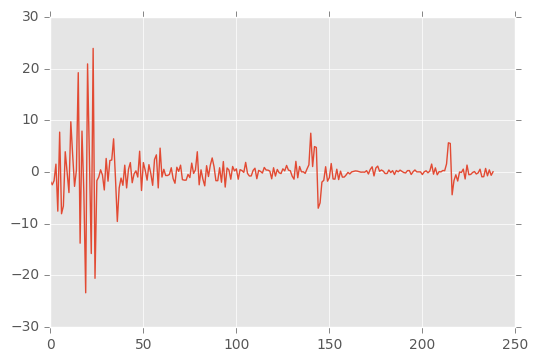

In [28]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -1.462021e+01
p-value                        3.895774e-27
#Lags Used                     2.000000e+00
Number of Observations Used    2.360000e+02
Critical Value (5%)           -2.873866e+00
Critical Value (1%)           -3.458366e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.031833
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


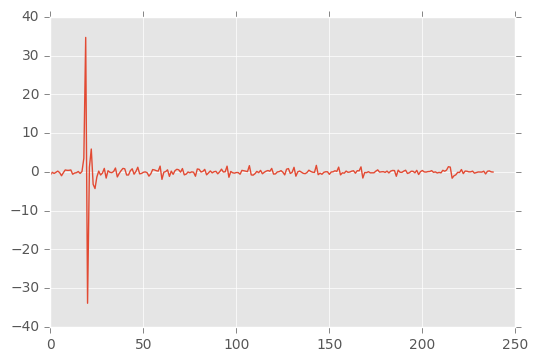

In [29]:
test_stationarity(diff_series(df_var_t['infr']))

In [30]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [31]:
STEPS = 8
LAG = 4

In [32]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [33]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [34]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='m')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'rmse': 0.71591246466068093, 'mae': 0.64018623807218866, 'mse': 0.51253065705653078}
{'rmse': 0.33378614728948969, 'mae': 0.2421391295046193, 'mse': 0.11141319212236091}
{'rmse': 0.16421913231026769, 'mae': 0.1290841844391365, 'mse': 0.026967923416737205}


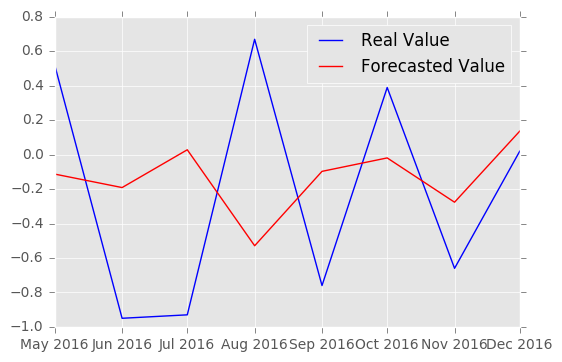

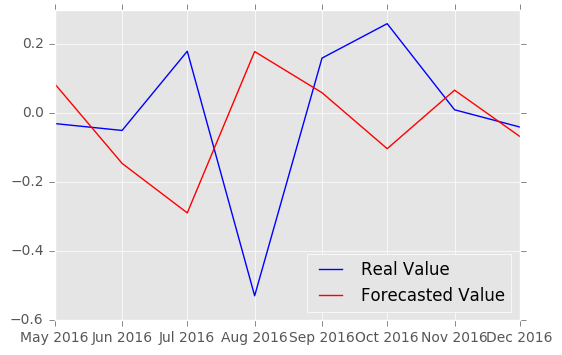

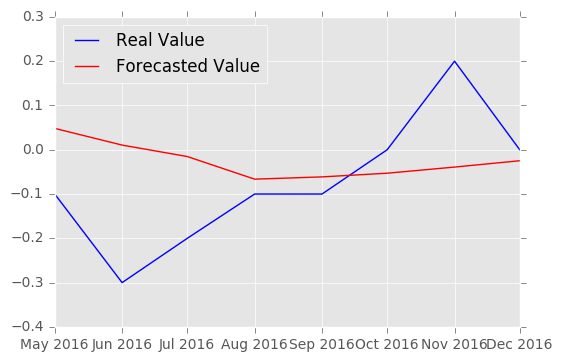

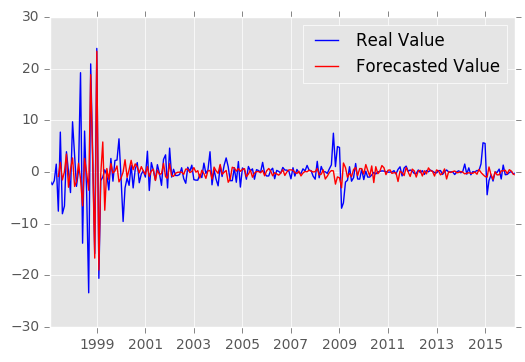

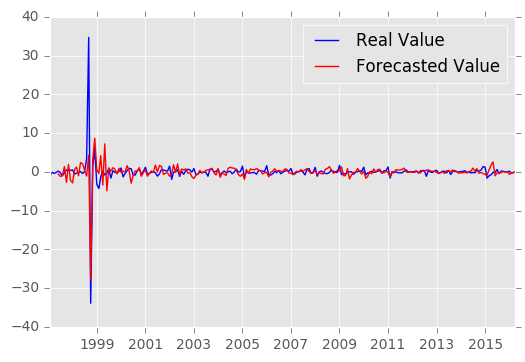

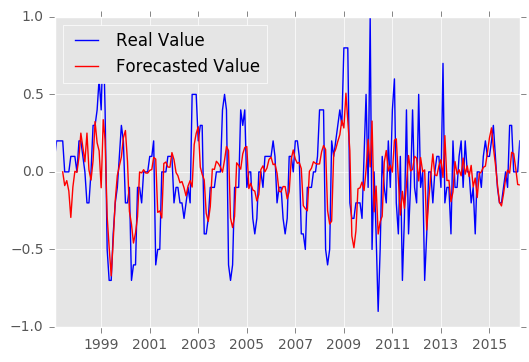

In [35]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

{'rmse': 0.57132150201872522, 'mae': 0.47637296811146723, 'mse': 0.32640825866893225}
{'rmse': 0.22418088569695419, 'mae': 0.19106452873135346, 'mse': 0.050257069511870839}
{'rmse': 0.54712631490665664, 'mae': 0.51604005118386531, 'mse': 0.29934720446333807}


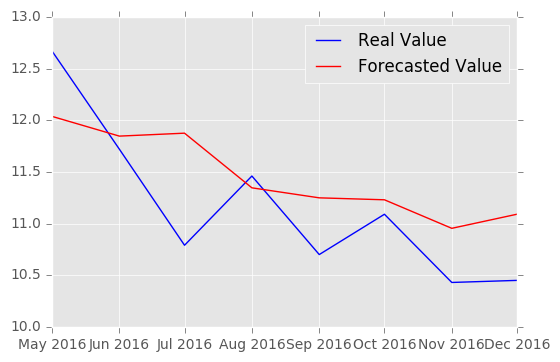

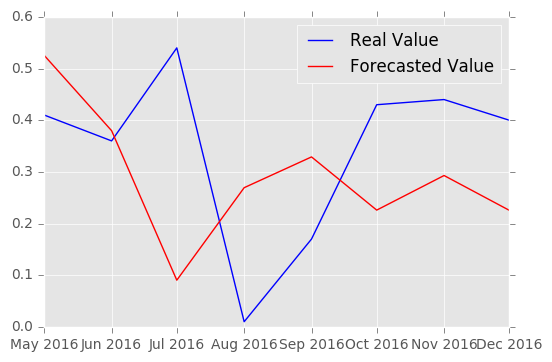

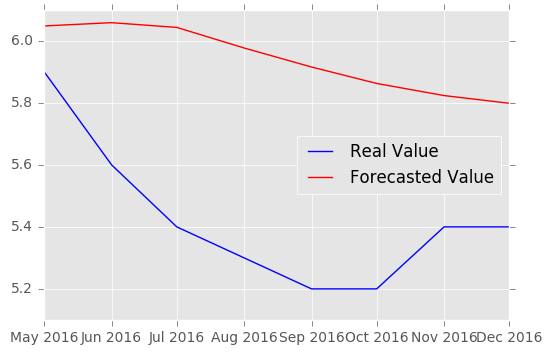

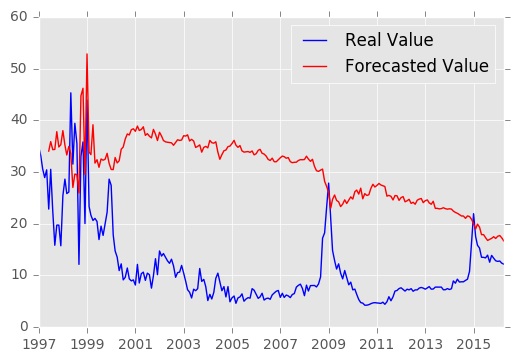

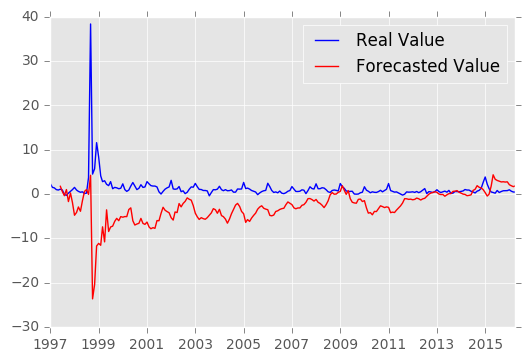

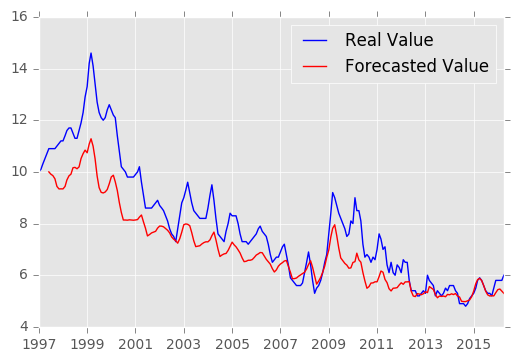

In [36]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

## ANN

In [37]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [38]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='m'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [39]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [40]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
0s - loss: 1.1573
Epoch 2/500
0s - loss: 0.9942
Epoch 3/500
0s - loss: 0.9853
Epoch 4/500
0s - loss: 0.9738
Epoch 5/500
0s - loss: 0.9692
Epoch 6/500
0s - loss: 0.9579
Epoch 7/500
0s - loss: 0.9516
Epoch 8/500
0s - loss: 0.9421
Epoch 9/500
0s - loss: 0.9337
Epoch 10/500
0s - loss: 0.9229
Epoch 11/500
0s - loss: 0.9145
Epoch 12/500
0s - loss: 0.9055
Epoch 13/500
0s - loss: 0.8946
Epoch 14/500
0s - loss: 0.8858
Epoch 15/500
0s - loss: 0.8775
Epoch 16/500
0s - loss: 0.8689
Epoch 17/500
0s - loss: 0.8605
Epoch 18/500
0s - loss: 0.8528
Epoch 19/500
0s - loss: 0.8466
Epoch 20/500
0s - loss: 0.8405
Epoch 21/500
0s - loss: 0.8355
Epoch 22/500
0s - loss: 0.8283
Epoch 23/500
0s - loss: 0.8217
Epoch 24/500
0s - loss: 0.8168
Epoch 25/500
0s - loss: 0.8111
Epoch 26/500
0s - loss: 0.8048
Epoch 27/500
0s - loss: 0.8041
Epoch 28/500
0s - loss: 0.7956
Epoch 29/500
0s - loss: 0.7923
Epoch 30/500
0s - loss: 0.7889
Epoch 31/500
0s - loss: 0.7831
Epoch 32/500
0s - loss: 0.7806
Epoch 33/500
0s -

{'rmse': 2.1147051456773824, 'mae': 1.8110245675212888, 'mse': 4.4719778531543986}
{'rmse': 0.53693606828689144, 'mae': 0.45335637586218147, 'mse': 0.28830034142738531}
{'rmse': 0.18211380248437692, 'mae': 0.13784391571549953, 'mse': 0.033165437055318644}


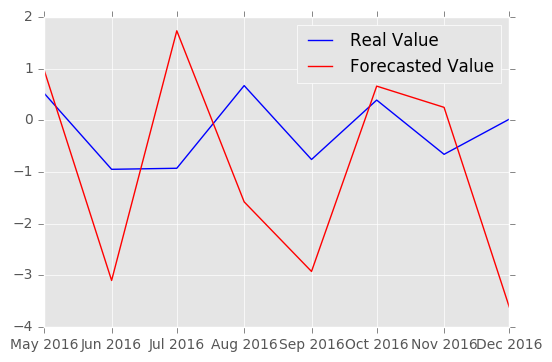

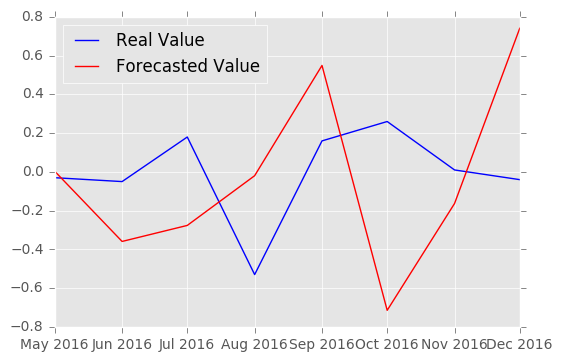

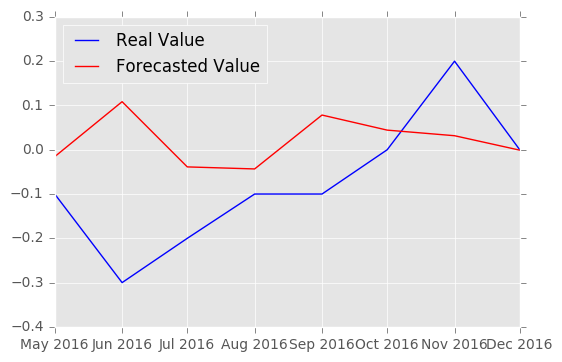

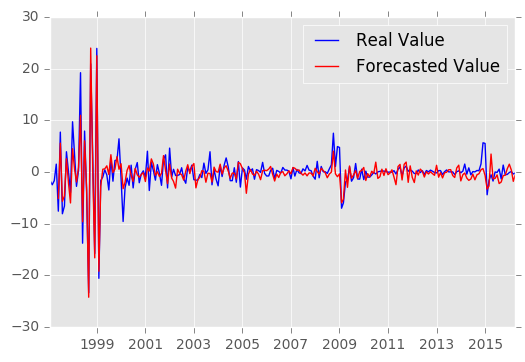

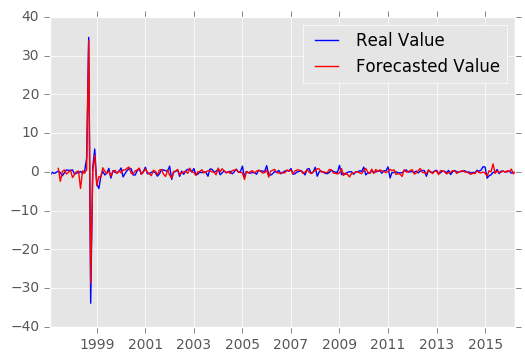

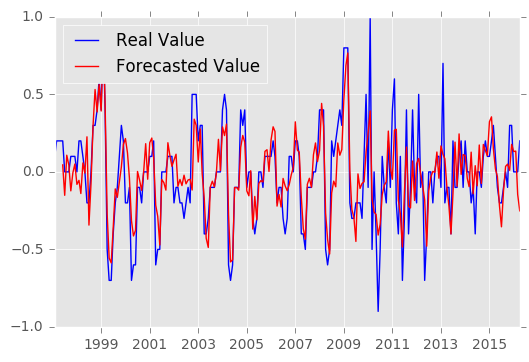

In [41]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'rmse': 2.9179100227860562, 'mae': 2.4072069165756345, 'mse': 8.5141989010753232}
{'rmse': 0.54095612886991673, 'mae': 0.42700144231887849, 'mse': 0.29263353336192593}
{'rmse': 0.70842904804619944, 'mae': 0.66180663289939112, 'mse': 0.5018717161156443}


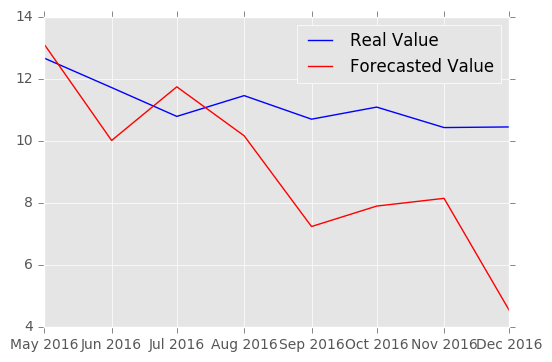

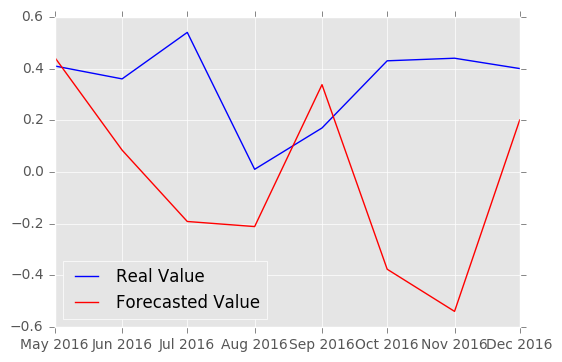

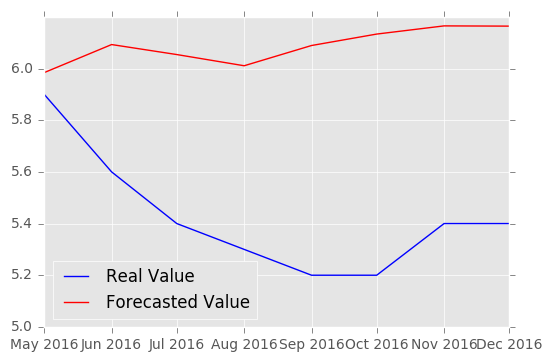

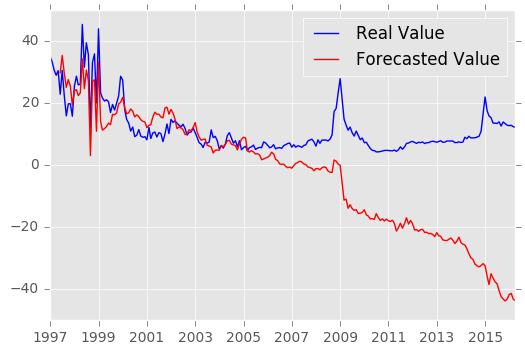

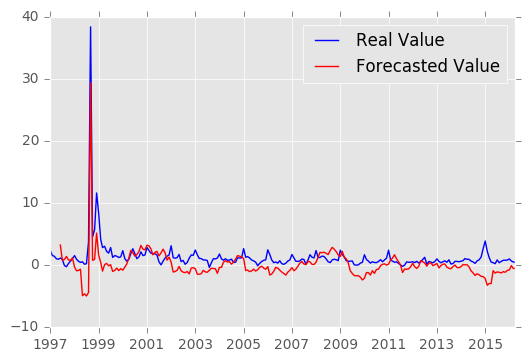

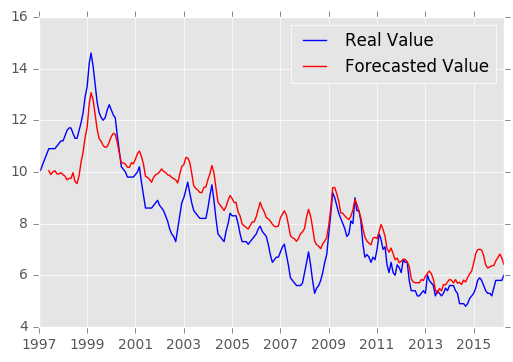

In [42]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск

In [43]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
1s - loss: 1.3465
Epoch 2/600
0s - loss: 1.0235
Epoch 3/600
0s - loss: 1.0018
Epoch 4/600
0s - loss: 0.9936
Epoch 5/600
0s - loss: 0.9839
Epoch 6/600
0s - loss: 0.9748
Epoch 7/600
0s - loss: 0.9665
Epoch 8/600
0s - loss: 0.9566
Epoch 9/600
0s - loss: 0.9493
Epoch 10/600
0s - loss: 0.9400
Epoch 11/600
0s - loss: 0.9317
Epoch 12/600
0s - loss: 0.9254
Epoch 13/600
0s - loss: 0.9168
Epoch 14/600
0s - loss: 0.9116
Epoch 15/600
0s - loss: 0.9061
Epoch 16/600
0s - loss: 0.8997
Epoch 17/600
0s - loss: 0.8944
Epoch 18/600
0s - loss: 0.8884
Epoch 19/600
0s - loss: 0.8823
Epoch 20/600
0s - loss: 0.8777
Epoch 21/600
0s - loss: 0.8730
Epoch 22/600
0s - loss: 0.8698
Epoch 23/600
0s - loss: 0.8618
Epoch 24/600
0s - loss: 0.8565
Epoch 25/600
0s - loss: 0.8520
Epoch 26/600
0s - loss: 0.8463
Epoch 27/600
0s - loss: 0.8417
Epoch 28/600
0s - loss: 0.8351
Epoch 29/600
0s - loss: 0.8288
Epoch 30/600
0s - loss: 0.8262
Epoch 31/600
0s - loss: 0.8197
Epoch 32/600
0s - loss: 0.8153
Epoch 33/600
0s -

{'rmse': 0.85957852550453184, 'mae': 0.71201847610033364, 'mse': 0.73887524150854511}
{'rmse': 0.47098873725590218, 'mae': 0.41965853206796905, 'mse': 0.22183039062190923}
{'rmse': 0.16730445028955146, 'mae': 0.13735607522564097, 'mse': 0.027990779086688997}


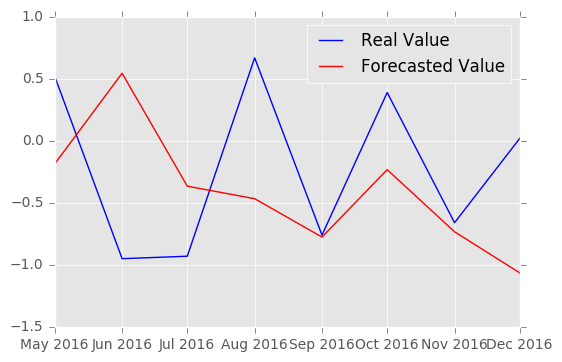

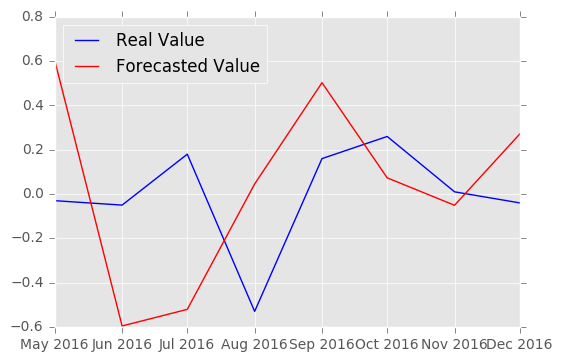

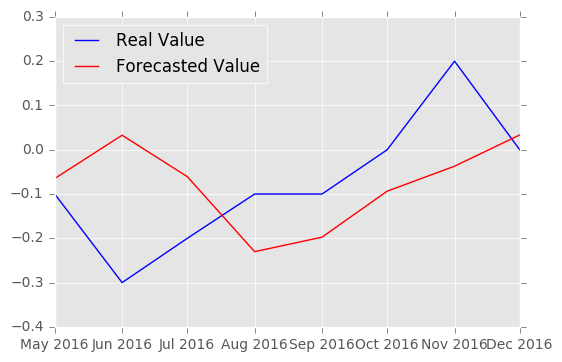

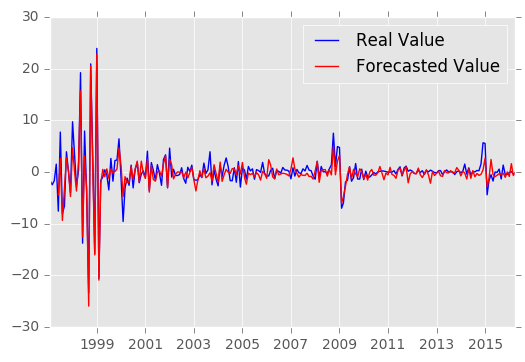

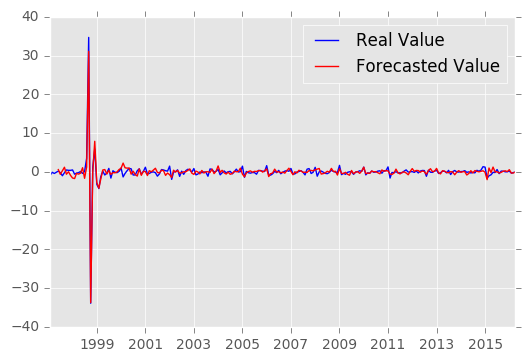

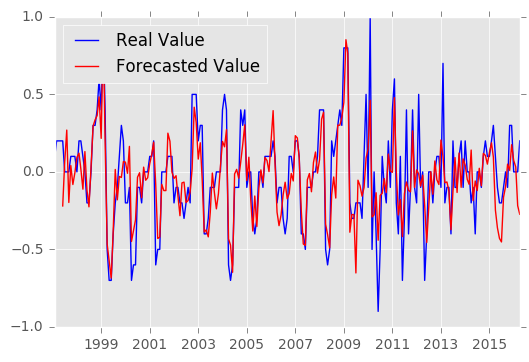

In [44]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'rmse': 0.86226732954945995, 'mae': 0.71988801696095628, 'mse': 0.74350494760835706}
{'rmse': 0.35927838613106339, 'mae': 0.27768885531435766, 'mse': 0.12908095874094147}
{'rmse': 0.2854312819918236, 'mae': 0.22771762780439342, 'mse': 0.08147101673949593}


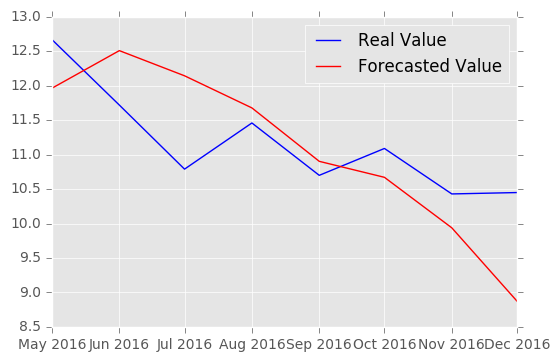

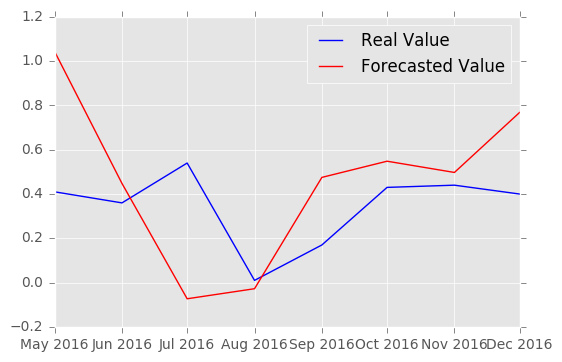

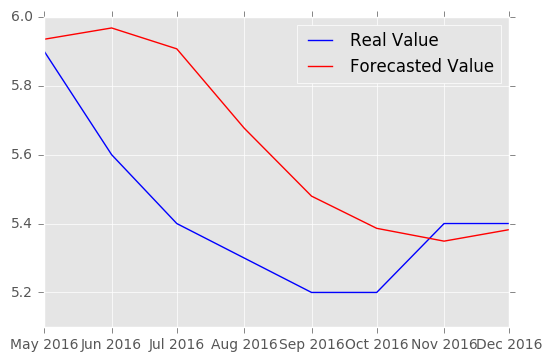

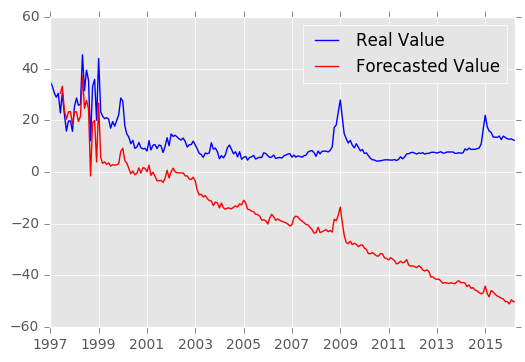

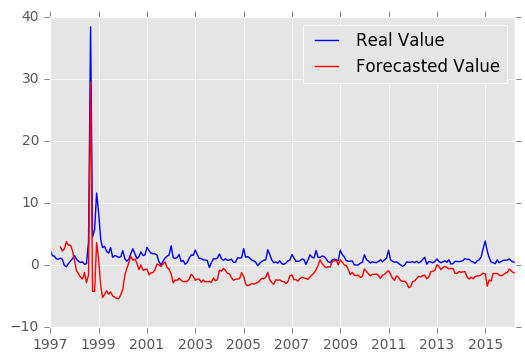

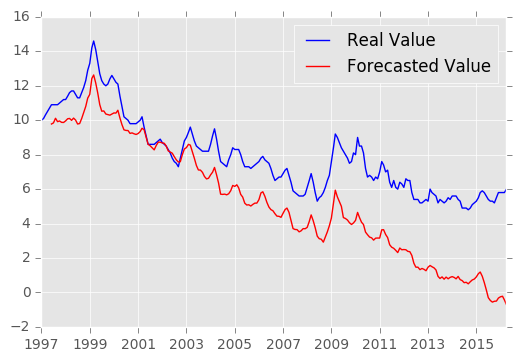

In [45]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

С DropOut

In [46]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
1s - loss: 1.2245
Epoch 2/600
0s - loss: 1.0578
Epoch 3/600
0s - loss: 1.0300
Epoch 4/600
1s - loss: 1.0175
Epoch 5/600
1s - loss: 1.0181
Epoch 6/600
0s - loss: 1.0035
Epoch 7/600
0s - loss: 0.9894
Epoch 8/600
0s - loss: 1.0043
Epoch 9/600
0s - loss: 1.0078
Epoch 10/600
0s - loss: 1.0100
Epoch 11/600
0s - loss: 0.9929
Epoch 12/600
0s - loss: 0.9908
Epoch 13/600
0s - loss: 0.9979
Epoch 14/600
0s - loss: 1.0019
Epoch 15/600
0s - loss: 0.9945
Epoch 16/600
0s - loss: 0.9750
Epoch 17/600
0s - loss: 0.9931
Epoch 18/600
0s - loss: 0.9769
Epoch 19/600
0s - loss: 0.9779
Epoch 20/600
0s - loss: 0.9767
Epoch 21/600
0s - loss: 0.9705
Epoch 22/600
0s - loss: 0.9712
Epoch 23/600
0s - loss: 0.9662
Epoch 24/600
0s - loss: 0.9727
Epoch 25/600
0s - loss: 0.9697
Epoch 26/600
0s - loss: 0.9581
Epoch 27/600
0s - loss: 0.9543
Epoch 28/600
0s - loss: 0.9534
Epoch 29/600
0s - loss: 0.9621
Epoch 30/600
0s - loss: 0.9474
Epoch 31/600
0s - loss: 0.9443
Epoch 32/600
0s - loss: 0.9473
Epoch 33/600
0s -

{'rmse': 0.72074900091200644, 'mae': 0.64683538296725951, 'mse': 0.51947912231565541}
{'rmse': 0.22806376477975412, 'mae': 0.17540230642632204, 'mse': 0.052013080805515019}
{'rmse': 0.16471829207049044, 'mae': 0.13406798886443685, 'mse': 0.027132115742619395}


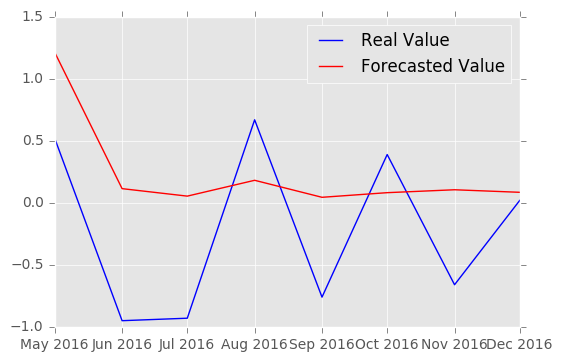

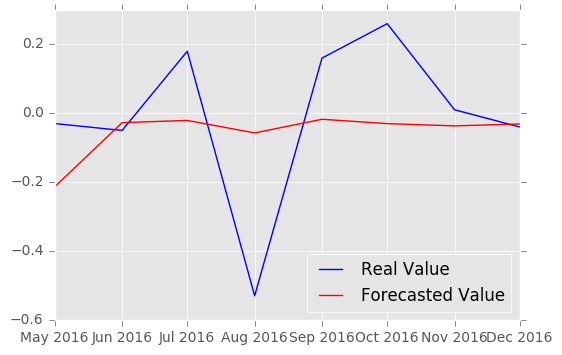

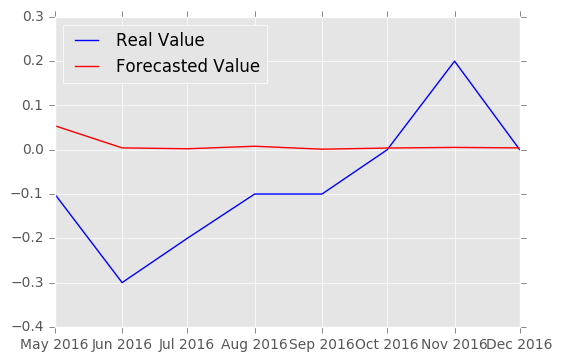

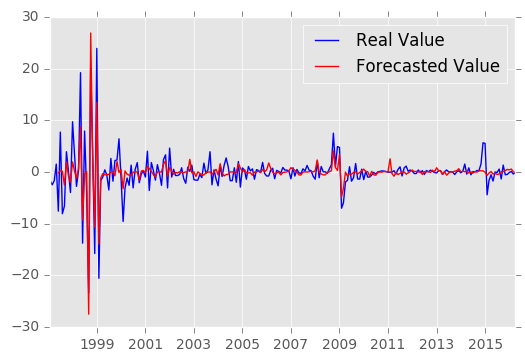

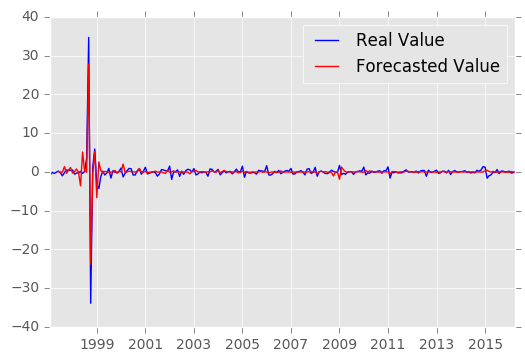

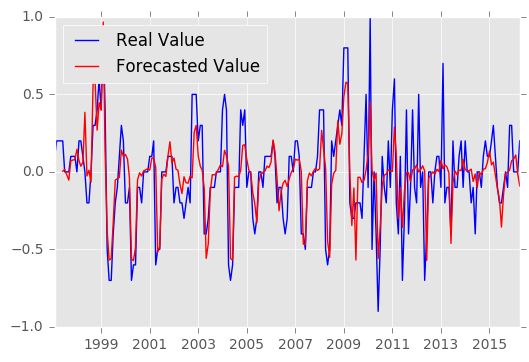

In [47]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['umpr'], test['umpr']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['umpr'], test['umpr'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['umpr'], train['umpr'])

{'rmse': 2.7006894574678975, 'mae': 2.5456948485290187, 'mse': 7.2937235456782465}
{'rmse': 0.2858402295903153, 'mae': 0.25494804673489763, 'mse': 0.081704636852244161}
{'rmse': 0.68086449085207867, 'mae': 0.64342979208963857, 'mse': 0.46357645490326027}


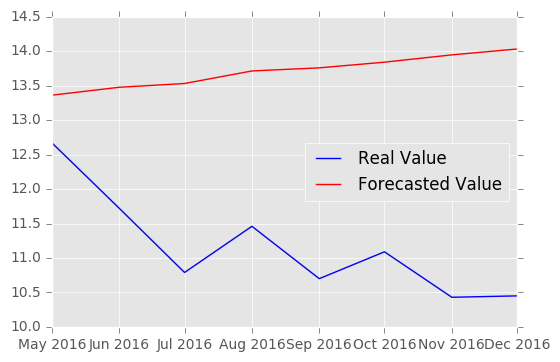

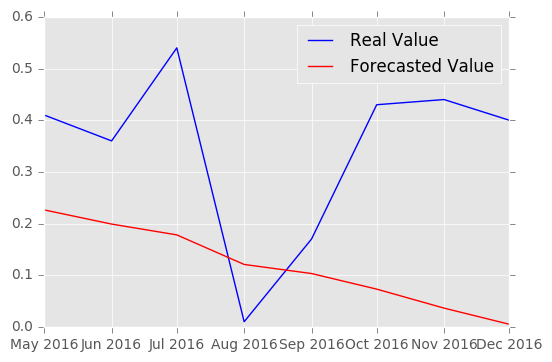

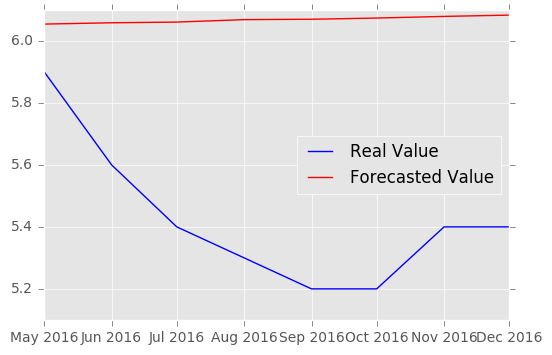

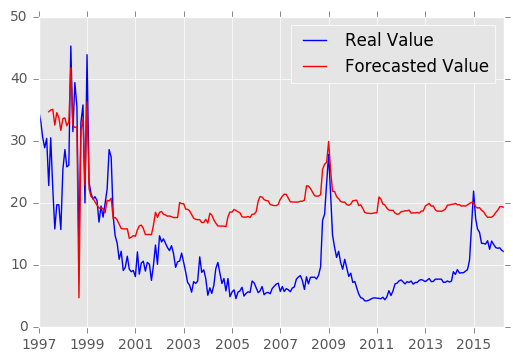

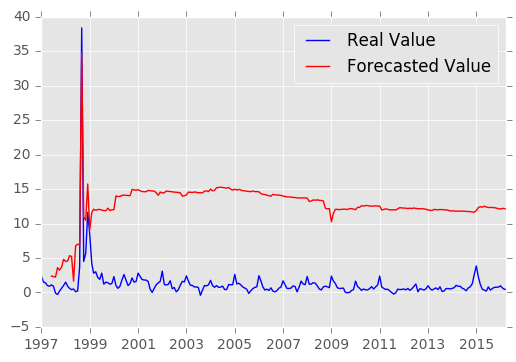

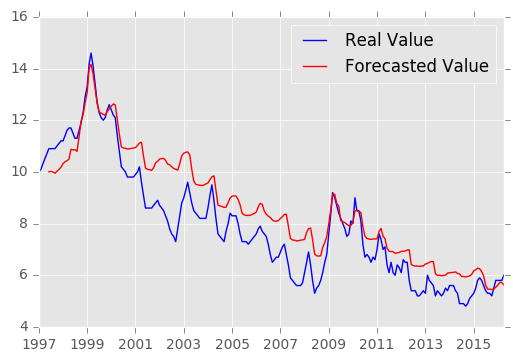

In [48]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

На оригинальных данных, а не разницах

In [49]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [50]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
1s - loss: 0.9957
Epoch 2/600
0s - loss: 0.8583
Epoch 3/600
0s - loss: 0.7473
Epoch 4/600
0s - loss: 0.6540
Epoch 5/600
0s - loss: 0.5897
Epoch 6/600
0s - loss: 0.5477
Epoch 7/600
0s - loss: 0.5177
Epoch 8/600
0s - loss: 0.4953
Epoch 9/600
0s - loss: 0.4758
Epoch 10/600
0s - loss: 0.4597
Epoch 11/600
0s - loss: 0.4439
Epoch 12/600
0s - loss: 0.4303
Epoch 13/600
0s - loss: 0.4164
Epoch 14/600
0s - loss: 0.4068
Epoch 15/600
0s - loss: 0.3969
Epoch 16/600
0s - loss: 0.3887
Epoch 17/600
0s - loss: 0.3830
Epoch 18/600
0s - loss: 0.3775
Epoch 19/600
0s - loss: 0.3740
Epoch 20/600
0s - loss: 0.3706
Epoch 21/600
0s - loss: 0.3676
Epoch 22/600
0s - loss: 0.3644
Epoch 23/600
0s - loss: 0.3613
Epoch 24/600
0s - loss: 0.3591
Epoch 25/600
0s - loss: 0.3573
Epoch 26/600
0s - loss: 0.3557
Epoch 27/600
0s - loss: 0.3536
Epoch 28/600
0s - loss: 0.3523
Epoch 29/600
0s - loss: 0.3506
Epoch 30/600
0s - loss: 0.3479
Epoch 31/600
0s - loss: 0.3462
Epoch 32/600
0s - loss: 0.3443
Epoch 33/600
0s -

{'rmse': 4.3202889594944534, 'mae': 4.2427176634536305, 'mse': 18.664896693529666}
{'rmse': 0.82803309965227923, 'mae': 0.73639571389955338, 'mse': 0.68563881411976135}
{'rmse': 3.1494790585098311, 'mae': 3.1331293824466191, 'mse': 9.9192183399919713}


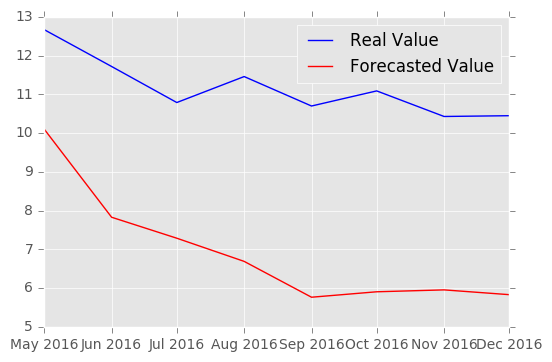

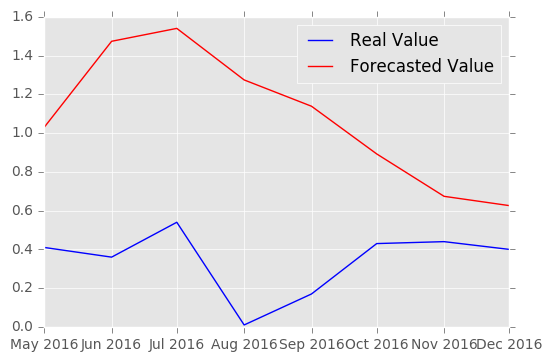

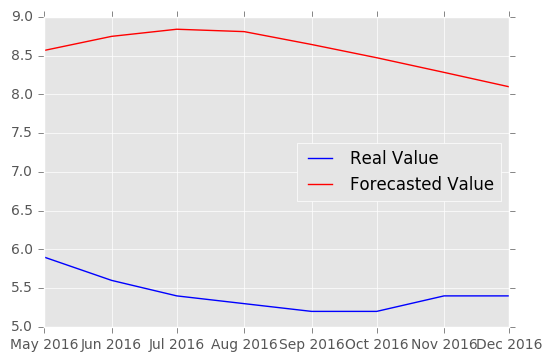

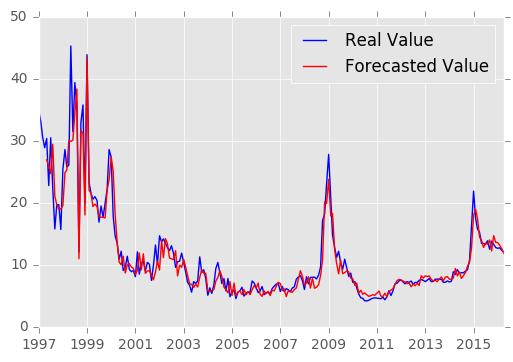

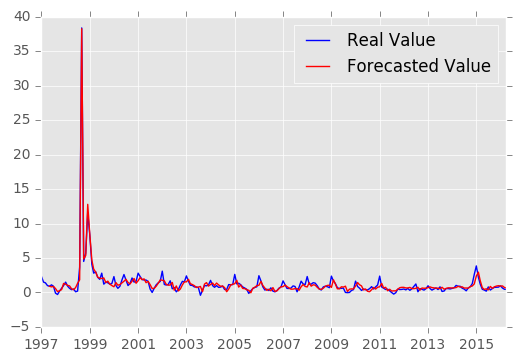

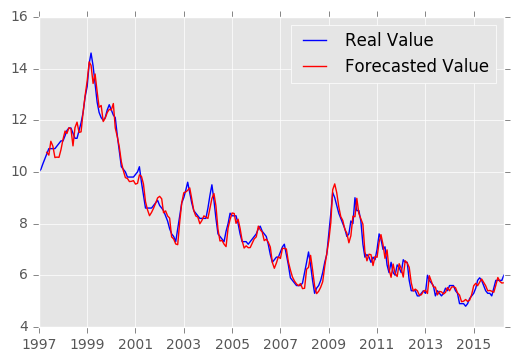

In [51]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

Второй запуск (не на разницах)

In [52]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
1s - loss: 1.1957
Epoch 2/600
0s - loss: 0.8947
Epoch 3/600
0s - loss: 0.8007
Epoch 4/600
0s - loss: 0.7120
Epoch 5/600
0s - loss: 0.6318
Epoch 6/600
0s - loss: 0.5736
Epoch 7/600
0s - loss: 0.5369
Epoch 8/600
0s - loss: 0.5120
Epoch 9/600
0s - loss: 0.4934
Epoch 10/600
0s - loss: 0.4777
Epoch 11/600
0s - loss: 0.4636
Epoch 12/600
0s - loss: 0.4502
Epoch 13/600
0s - loss: 0.4375
Epoch 14/600
0s - loss: 0.4252
Epoch 15/600
0s - loss: 0.4150
Epoch 16/600
0s - loss: 0.4047
Epoch 17/600
0s - loss: 0.3968
Epoch 18/600
0s - loss: 0.3897
Epoch 19/600
0s - loss: 0.3869
Epoch 20/600
0s - loss: 0.3812
Epoch 21/600
0s - loss: 0.3783
Epoch 22/600
0s - loss: 0.3750
Epoch 23/600
0s - loss: 0.3733
Epoch 24/600
0s - loss: 0.3706
Epoch 25/600
0s - loss: 0.3694
Epoch 26/600
0s - loss: 0.3676
Epoch 27/600
0s - loss: 0.3656
Epoch 28/600
0s - loss: 0.3638
Epoch 29/600
0s - loss: 0.3627
Epoch 30/600
0s - loss: 0.3616
Epoch 31/600
0s - loss: 0.3598
Epoch 32/600
0s - loss: 0.3592
Epoch 33/600
0s -

{'rmse': 3.9714737743164696, 'mae': 3.9474906847500018, 'mse': 15.772603940083506}
{'rmse': 0.55593172852955497, 'mae': 0.46641278485102916, 'mse': 0.30906008678585883}
{'rmse': 2.8139796531767538, 'mae': 2.7910790589318446, 'mse': 7.9184814884927626}


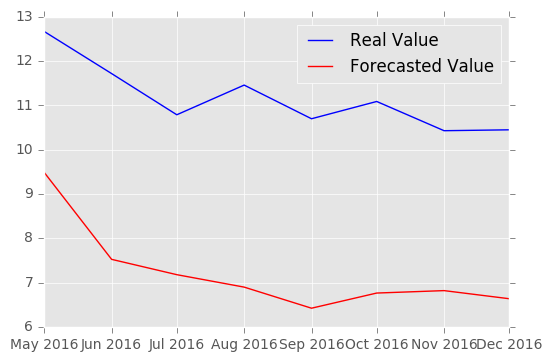

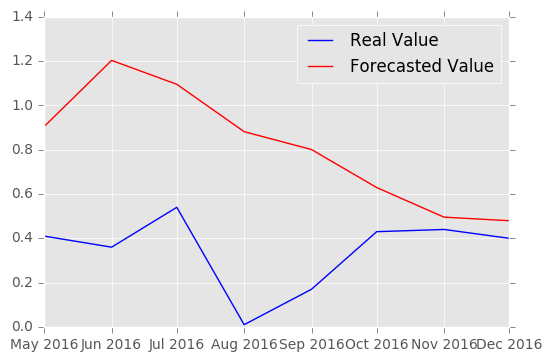

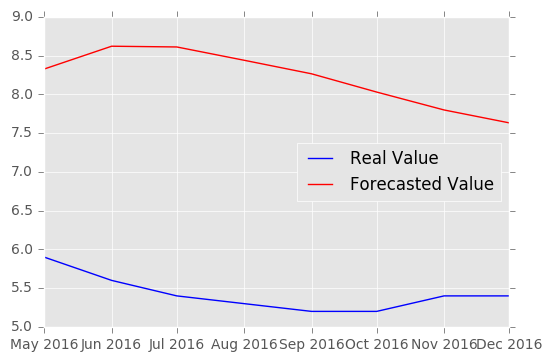

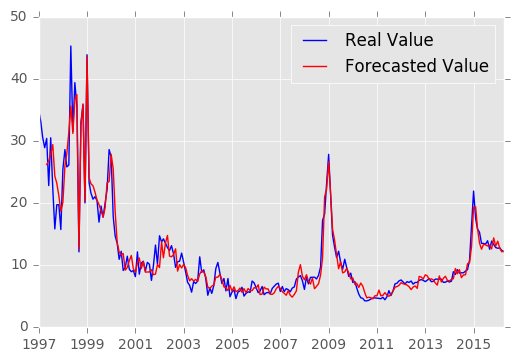

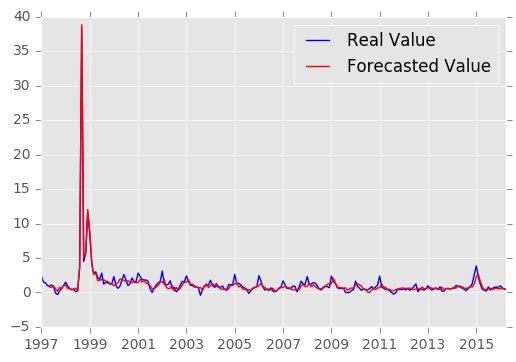

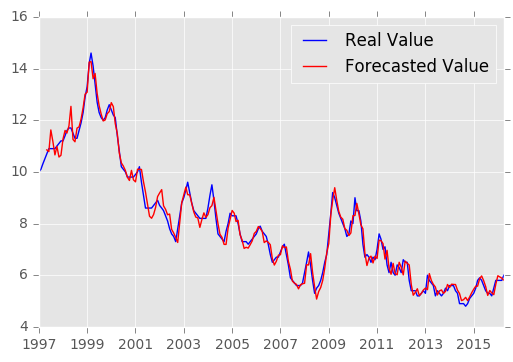

In [53]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

С DropOut

In [54]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
1s - loss: 1.0861
Epoch 2/600
0s - loss: 0.9266
Epoch 3/600
0s - loss: 0.8531
Epoch 4/600
0s - loss: 0.7810
Epoch 5/600
0s - loss: 0.7060
Epoch 6/600
0s - loss: 0.6379
Epoch 7/600
0s - loss: 0.5809
Epoch 8/600
0s - loss: 0.5375
Epoch 9/600
0s - loss: 0.5032
Epoch 10/600
0s - loss: 0.4771
Epoch 11/600
0s - loss: 0.4578
Epoch 12/600
0s - loss: 0.4414
Epoch 13/600
0s - loss: 0.4288
Epoch 14/600
0s - loss: 0.4183
Epoch 15/600
0s - loss: 0.4106
Epoch 16/600
0s - loss: 0.4015
Epoch 17/600
0s - loss: 0.3966
Epoch 18/600
0s - loss: 0.3917
Epoch 19/600
0s - loss: 0.3864
Epoch 20/600
0s - loss: 0.3822
Epoch 21/600
0s - loss: 0.3785
Epoch 22/600
0s - loss: 0.3760
Epoch 23/600
0s - loss: 0.3730
Epoch 24/600
0s - loss: 0.3710
Epoch 25/600
0s - loss: 0.3699
Epoch 26/600
0s - loss: 0.3665
Epoch 27/600
0s - loss: 0.3658
Epoch 28/600
0s - loss: 0.3652
Epoch 29/600
0s - loss: 0.3623
Epoch 30/600
0s - loss: 0.3618
Epoch 31/600
0s - loss: 0.3606
Epoch 32/600
0s - loss: 0.3586
Epoch 33/600
0s -

{'rmse': 4.4847013377103169, 'mae': 4.4173096526797604, 'mse': 20.112546088460704}
{'rmse': 0.73856938313447928, 'mae': 0.70594981924778222, 'mse': 0.54548473370364525}
{'rmse': 2.661962875331628, 'mae': 2.636954036002626, 'mse': 7.0860463496438282}


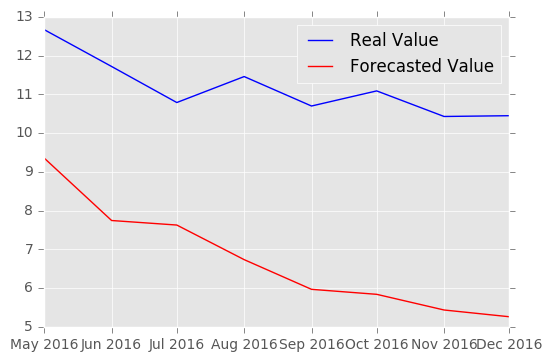

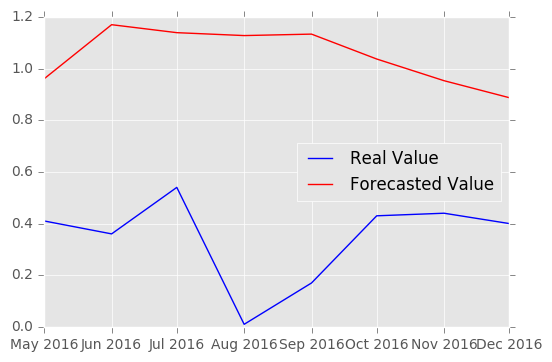

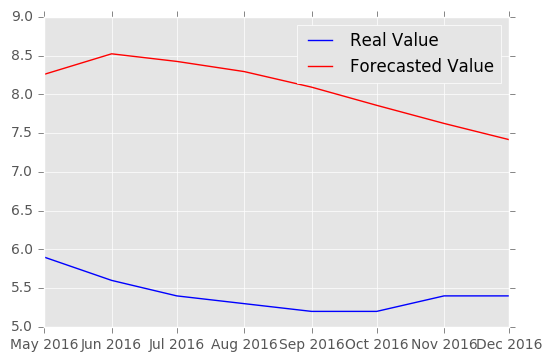

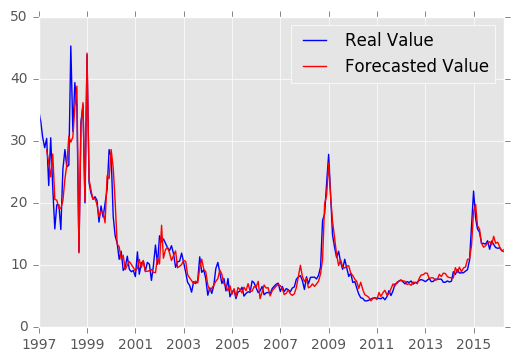

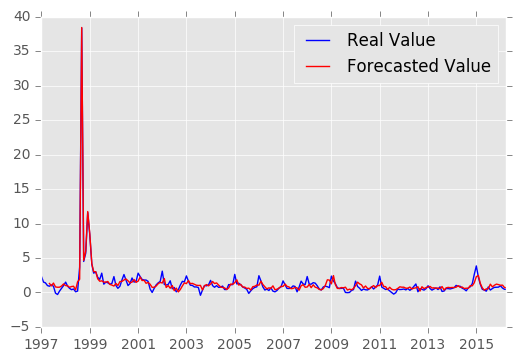

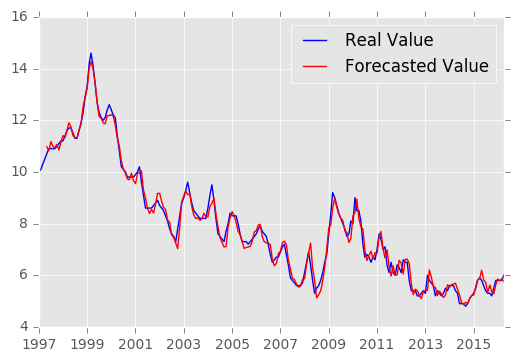

In [55]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['umpr'], test_real['umpr']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['umpr'], test_real['umpr'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['umpr'], train_real['umpr'])

## Hybrid

In [56]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [57]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [58]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.1464
Epoch 2/200
0s - loss: 1.0078
Epoch 3/200
0s - loss: 1.0040
Epoch 4/200
0s - loss: 1.0023
Epoch 5/200
0s - loss: 1.0036
Epoch 6/200
0s - loss: 0.9985
Epoch 7/200
0s - loss: 1.0001
Epoch 8/200
0s - loss: 0.9994
Epoch 9/200
0s - loss: 0.9951
Epoch 10/200
0s - loss: 0.9946
Epoch 11/200
0s - loss: 0.9949
Epoch 12/200
0s - loss: 0.9916
Epoch 13/200
0s - loss: 0.9906
Epoch 14/200
0s - loss: 0.9910
Epoch 15/200
0s - loss: 0.9890
Epoch 16/200
0s - loss: 0.9861
Epoch 17/200
0s - loss: 0.9840
Epoch 18/200
0s - loss: 0.9855
Epoch 19/200
0s - loss: 0.9824
Epoch 20/200
0s - loss: 0.9825
Epoch 21/200
0s - loss: 0.9830
Epoch 22/200
0s - loss: 0.9799
Epoch 23/200
0s - loss: 0.9766
Epoch 24/200
0s - loss: 0.9768
Epoch 25/200
0s - loss: 0.9752
Epoch 26/200
0s - loss: 0.9753
Epoch 27/200
0s - loss: 0.9753
Epoch 28/200
0s - loss: 0.9722
Epoch 29/200
0s - loss: 0.9707
Epoch 30/200
0s - loss: 0.9683
Epoch 31/200
0s - loss: 0.9669
Epoch 32/200
0s - loss: 0.9660
Epoch 33/200
0s -

{'rmse': 1.2640134627309234, 'mae': 1.0315489731995595, 'mse': 1.5977300339650196}
{'rmse': 0.7143769849938546, 'mae': 0.63114734593855615, 'mse': 0.51033447668890997}
{'rmse': 0.15231289538784754, 'mae': 0.12751114736534902, 'mse': 0.023199218101429383}


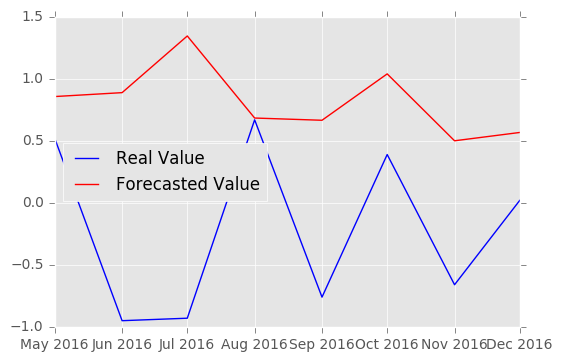

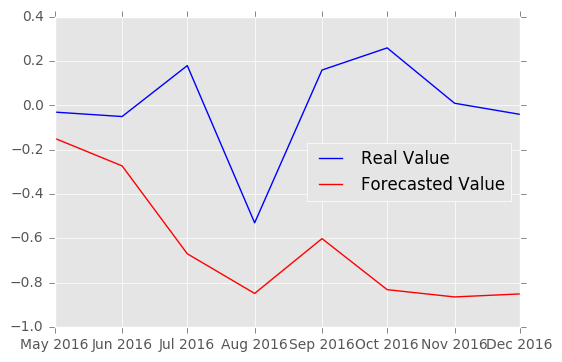

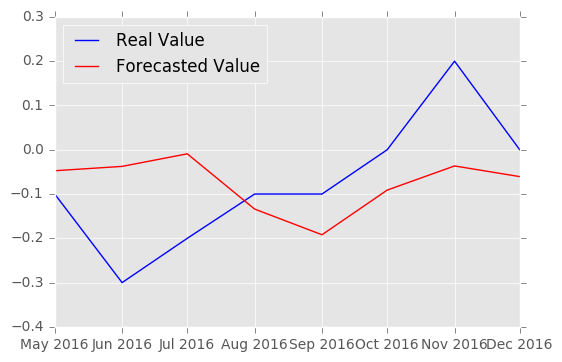

In [59]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'rmse': 5.5861752440400902, 'mae': 4.9784549351429321, 'mse': 31.205353857126358}
{'rmse': 2.8229963558908984, 'mae': 2.2603045353297619, 'mse': 7.9693084253732911}
{'rmse': 0.31839438469569115, 'mae': 0.25932576468512791, 'mse': 0.10137498420574777}


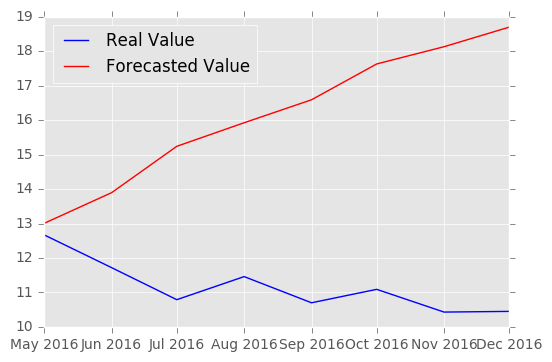

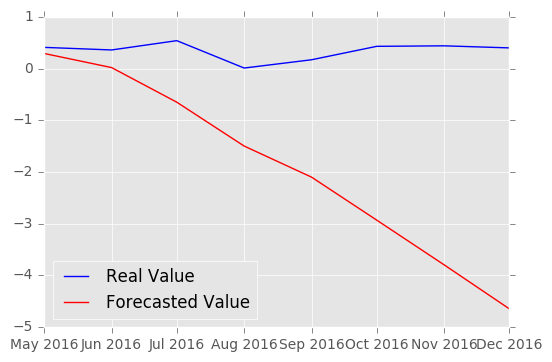

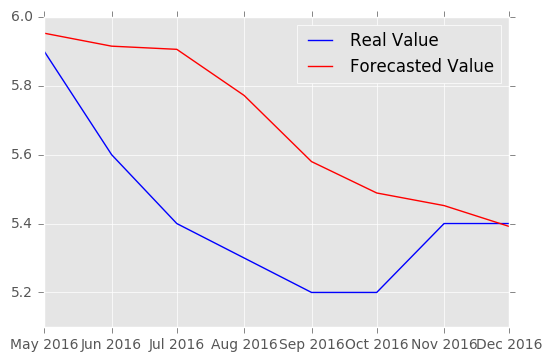

In [60]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [61]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.0017
Epoch 2/200
0s - loss: 0.9959
Epoch 3/200
0s - loss: 0.9938
Epoch 4/200
0s - loss: 0.9933
Epoch 5/200
0s - loss: 0.9921
Epoch 6/200
0s - loss: 0.9911
Epoch 7/200
0s - loss: 0.9883
Epoch 8/200
0s - loss: 0.9864
Epoch 9/200
0s - loss: 0.9846
Epoch 10/200
0s - loss: 0.9859
Epoch 11/200
0s - loss: 0.9794
Epoch 12/200
0s - loss: 0.9813
Epoch 13/200
0s - loss: 0.9802
Epoch 14/200
0s - loss: 0.9799
Epoch 15/200
0s - loss: 0.9760
Epoch 16/200
0s - loss: 0.9736
Epoch 17/200
0s - loss: 0.9717
Epoch 18/200
0s - loss: 0.9699
Epoch 19/200
0s - loss: 0.9697
Epoch 20/200
0s - loss: 0.9662
Epoch 21/200
0s - loss: 0.9652
Epoch 22/200
0s - loss: 0.9618
Epoch 23/200
0s - loss: 0.9625
Epoch 24/200
0s - loss: 0.9577
Epoch 25/200
0s - loss: 0.9552
Epoch 26/200
0s - loss: 0.9542
Epoch 27/200
0s - loss: 0.9546
Epoch 28/200
0s - loss: 0.9512
Epoch 29/200
0s - loss: 0.9487
Epoch 30/200
0s - loss: 0.9463
Epoch 31/200
0s - loss: 0.9466
Epoch 32/200
0s - loss: 0.9437
Epoch 33/200
0s -

{'rmse': 1.0214140292073677, 'mae': 0.84477036276684658, 'mse': 1.0432866190616294}
{'rmse': 0.67271604782024819, 'mae': 0.5814452890112205, 'mse': 0.45254688099489448}
{'rmse': 0.1360011391874846, 'mae': 0.10751118001621315, 'mse': 0.018496309860293561}


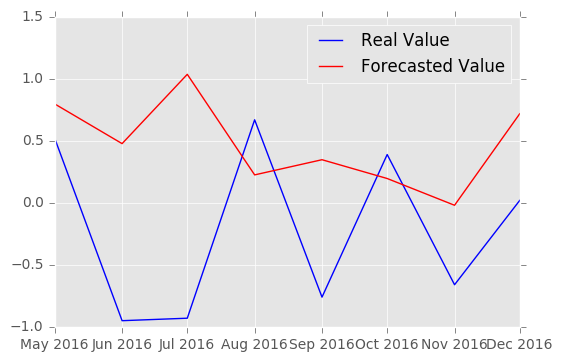

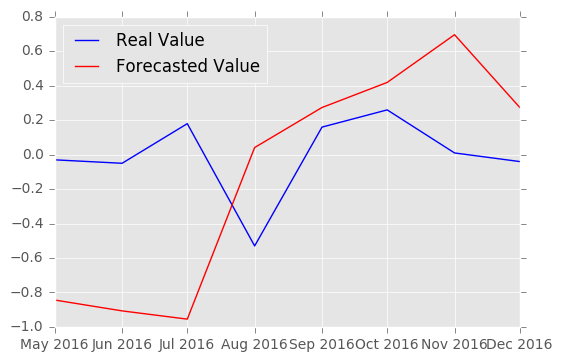

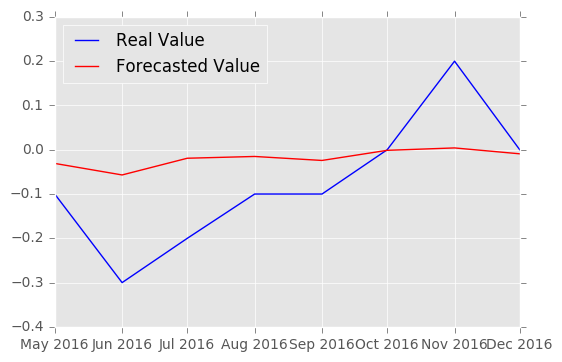

In [62]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'rmse': 3.8049823098387265, 'mae': 3.4540181034782256, 'mse': 14.477890378185652}
{'rmse': 1.8444788007511557, 'mae': 1.730467757104599, 'mse': 3.4021020464204215}
{'rmse': 0.49252518239960597, 'mae': 0.45776359742020734, 'mse': 0.24258105529776514}


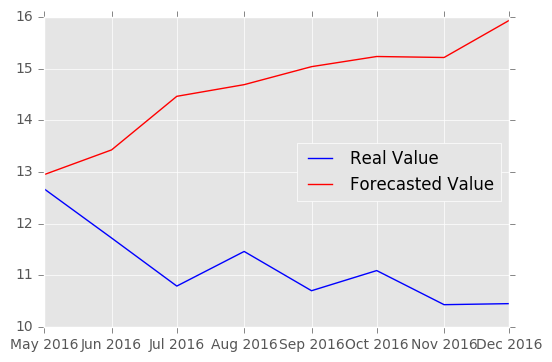

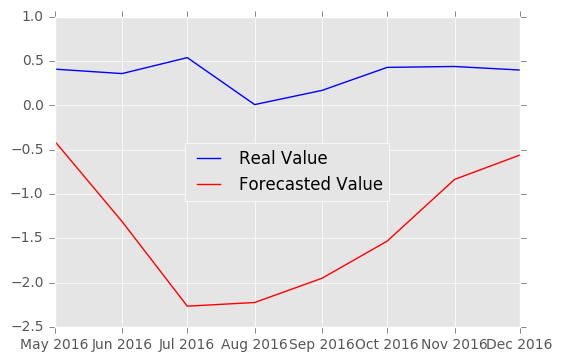

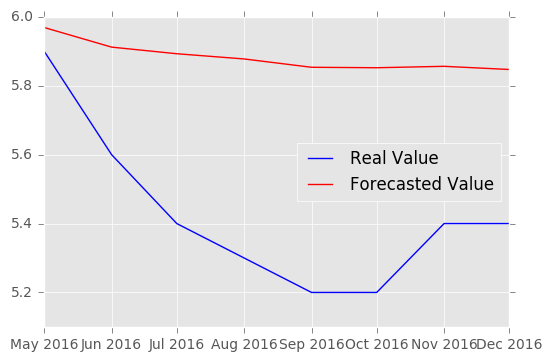

In [63]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='m')

Epoch 1/200
1s - loss: 1.1644
Epoch 2/200
0s - loss: 1.0243
Epoch 3/200
0s - loss: 1.0149
Epoch 4/200
0s - loss: 1.0207
Epoch 5/200
0s - loss: 1.0080
Epoch 6/200
0s - loss: 1.0103
Epoch 7/200
0s - loss: 1.0225
Epoch 8/200
0s - loss: 1.0237
Epoch 9/200
0s - loss: 1.0058
Epoch 10/200
0s - loss: 1.0064
Epoch 11/200
0s - loss: 1.0111
Epoch 12/200
0s - loss: 0.9983
Epoch 13/200
0s - loss: 1.0036
Epoch 14/200
0s - loss: 1.0042
Epoch 15/200
0s - loss: 1.0078
Epoch 16/200
0s - loss: 1.0052
Epoch 17/200
0s - loss: 1.0075
Epoch 18/200
0s - loss: 1.0023
Epoch 19/200
0s - loss: 0.9973
Epoch 20/200
0s - loss: 0.9980
Epoch 21/200
0s - loss: 0.9916
Epoch 22/200
0s - loss: 0.9973
Epoch 23/200
0s - loss: 0.9955
Epoch 24/200
0s - loss: 0.9945
Epoch 25/200
0s - loss: 0.9958
Epoch 26/200
0s - loss: 0.9964
Epoch 27/200
0s - loss: 0.9903
Epoch 28/200
0s - loss: 0.9983
Epoch 29/200
0s - loss: 0.9946
Epoch 30/200
0s - loss: 0.9906
Epoch 31/200
0s - loss: 0.9986
Epoch 32/200
0s - loss: 0.9949
Epoch 33/200
0s -

{'rmse': 0.8513925999584151, 'mae': 0.71593172526220483, 'mse': 0.72486935926394991}
{'rmse': 0.48265246984459076, 'mae': 0.38576989575963322, 'mse': 0.23295340664708358}
{'rmse': 0.15259999615889169, 'mae': 0.12063200946421881, 'mse': 0.023286758827693758}


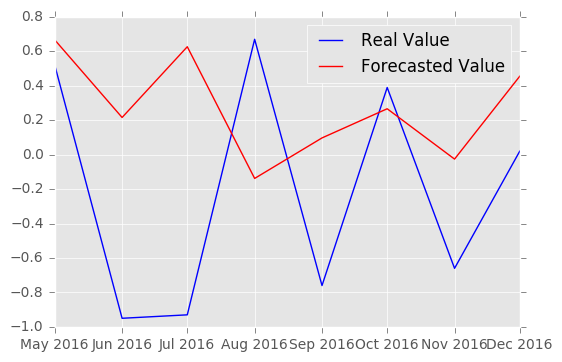

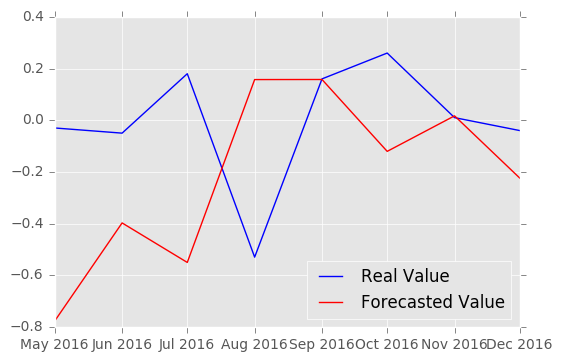

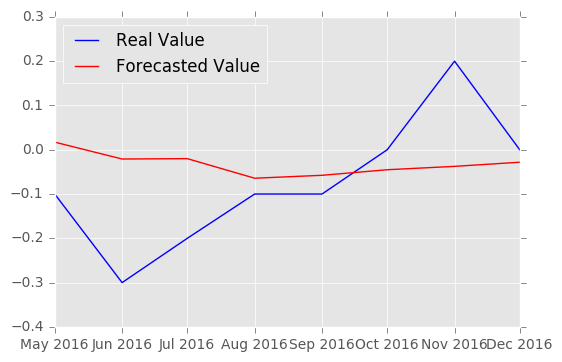

In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'rmse': 2.6751396384815678, 'mae': 2.4246401901021644, 'mse': 7.1563720853752937}
{'rmse': 1.3769221262020537, 'mae': 1.334579885148089, 'mse': 1.8959145416247845}
{'rmse': 0.49142554852171189, 'mae': 0.45995577348514682, 'mse': 0.2414990697398654}


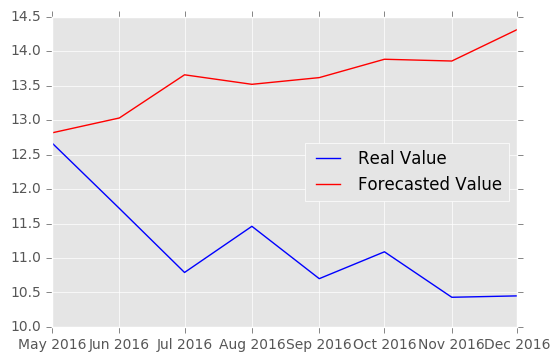

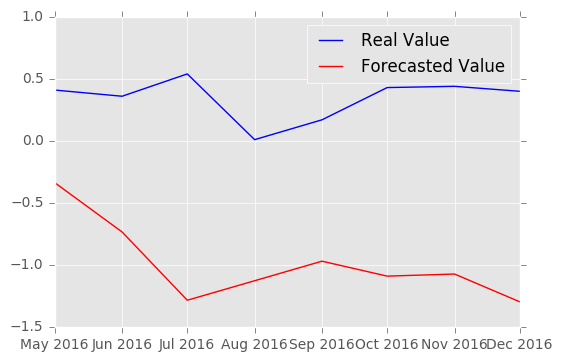

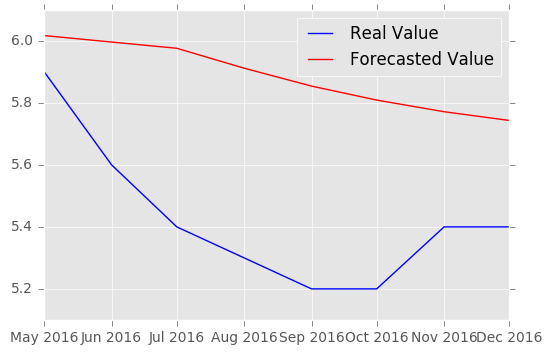

In [66]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid_full

In [67]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.1727
Epoch 2/500
0s - loss: 0.8672
Epoch 3/500
0s - loss: 0.7387
Epoch 4/500
0s - loss: 0.6452
Epoch 5/500
0s - loss: 0.5715
Epoch 6/500
0s - loss: 0.5128
Epoch 7/500
0s - loss: 0.4638
Epoch 8/500
0s - loss: 0.4210
Epoch 9/500
0s - loss: 0.3881
Epoch 10/500
0s - loss: 0.3629
Epoch 11/500
0s - loss: 0.3445
Epoch 12/500
0s - loss: 0.3297
Epoch 13/500
0s - loss: 0.3185
Epoch 14/500
0s - loss: 0.3084
Epoch 15/500
0s - loss: 0.2987
Epoch 16/500
0s - loss: 0.2915
Epoch 17/500
0s - loss: 0.2823
Epoch 18/500
0s - loss: 0.2738
Epoch 19/500
0s - loss: 0.2681
Epoch 20/500
0s - loss: 0.2606
Epoch 21/500
0s - loss: 0.2552
Epoch 22/500
0s - loss: 0.2487
Epoch 23/500
0s - loss: 0.2444
Epoch 24/500
0s - loss: 0.2394
Epoch 25/500
0s - loss: 0.2331
Epoch 26/500
0s - loss: 0.2300
Epoch 27/500
0s - loss: 0.2265
Epoch 28/500
0s - loss: 0.2234
Epoch 29/500
0s - loss: 0.2188
Epoch 30/500
0s - loss: 0.2160
Epoch 31/500
0s - loss: 0.2113
Epoch 32/500
0s - loss: 0.2086
Epoch 33/500
0s -

{'rmse': 13.547997481096901, 'mae': 9.4364528472182823, 'mse': 183.54823574780798}
{'rmse': 6.0966118316782936, 'mae': 5.4717977227502521, 'mse': 37.168675826159756}
{'rmse': 1.4576109467258289, 'mae': 1.4330241833121544, 'mse': 2.1246296720149673}


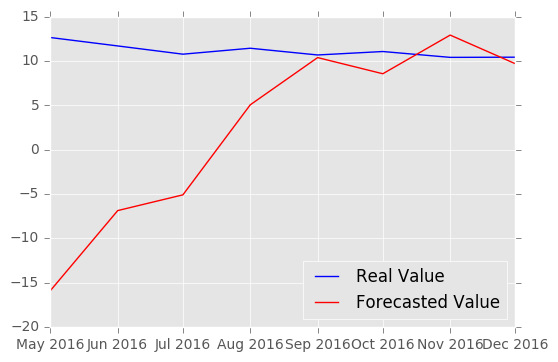

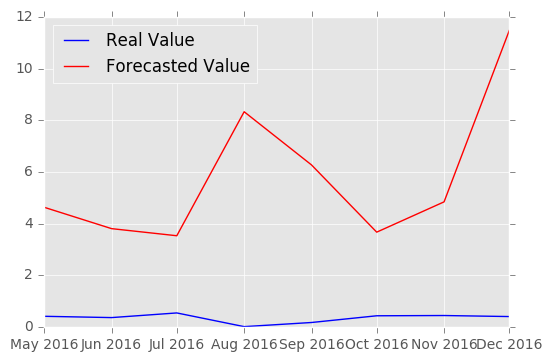

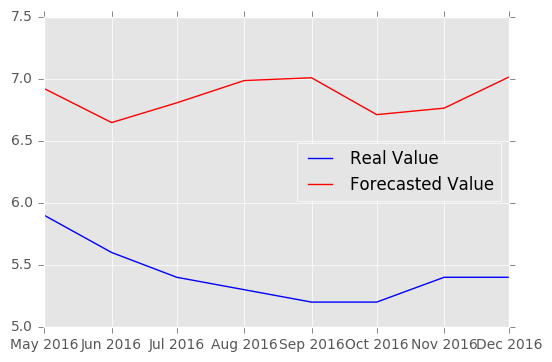

In [69]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [70]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.0815
Epoch 2/500
0s - loss: 0.8352
Epoch 3/500
0s - loss: 0.7289
Epoch 4/500
0s - loss: 0.6410
Epoch 5/500
0s - loss: 0.5727
Epoch 6/500
0s - loss: 0.5183
Epoch 7/500
0s - loss: 0.4741
Epoch 8/500
0s - loss: 0.4369
Epoch 9/500
0s - loss: 0.4069
Epoch 10/500
0s - loss: 0.3869
Epoch 11/500
0s - loss: 0.3641
Epoch 12/500
0s - loss: 0.3497
Epoch 13/500
0s - loss: 0.3364
Epoch 14/500
0s - loss: 0.3245
Epoch 15/500
0s - loss: 0.3147
Epoch 16/500
0s - loss: 0.3058
Epoch 17/500
0s - loss: 0.2965
Epoch 18/500
0s - loss: 0.2900
Epoch 19/500
0s - loss: 0.2837
Epoch 20/500
0s - loss: 0.2776
Epoch 21/500
0s - loss: 0.2702
Epoch 22/500
0s - loss: 0.2645
Epoch 23/500
0s - loss: 0.2592
Epoch 24/500
0s - loss: 0.2539
Epoch 25/500
0s - loss: 0.2482
Epoch 26/500
0s - loss: 0.2424
Epoch 27/500
0s - loss: 0.2405
Epoch 28/500
0s - loss: 0.2346
Epoch 29/500
0s - loss: 0.2292
Epoch 30/500
0s - loss: 0.2256
Epoch 31/500
0s - loss: 0.2229
Epoch 32/500
0s - loss: 0.2179
Epoch 33/500
0s -

{'rmse': 14.143882134073857, 'mae': 11.942728785974758, 'mse': 200.04940182257366}
{'rmse': 5.6369838276063424, 'mae': 5.1095180064366685, 'mse': 31.775586672695454}
{'rmse': 0.93040187646790229, 'mae': 0.86206398144207874, 'mse': 0.86564765173499381}


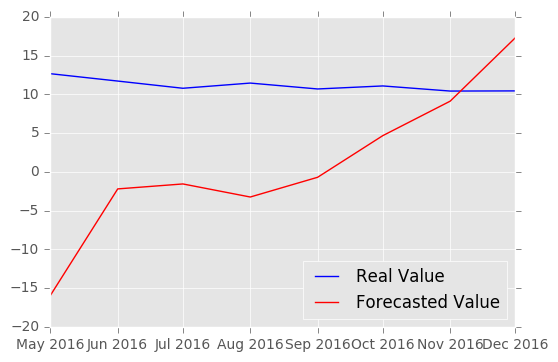

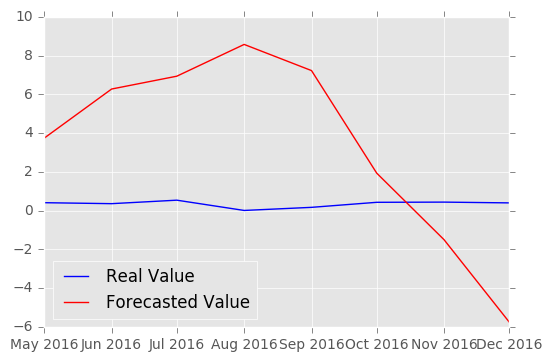

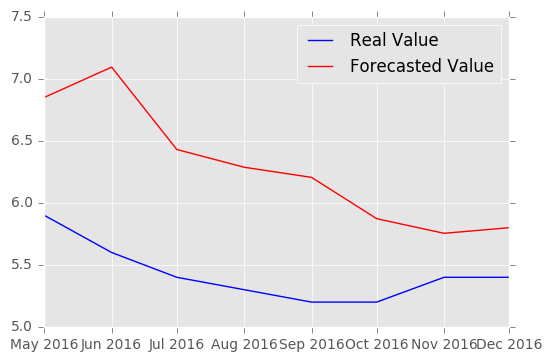

In [71]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [72]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.1474
Epoch 2/500
0s - loss: 1.0096
Epoch 3/500
0s - loss: 0.9767
Epoch 4/500
0s - loss: 0.9573
Epoch 5/500
0s - loss: 0.9662
Epoch 6/500
0s - loss: 0.9297
Epoch 7/500
0s - loss: 0.9024
Epoch 8/500
0s - loss: 0.8983
Epoch 9/500
0s - loss: 0.8625
Epoch 10/500
0s - loss: 0.8559
Epoch 11/500
0s - loss: 0.8218
Epoch 12/500
0s - loss: 0.8142
Epoch 13/500
0s - loss: 0.7943
Epoch 14/500
0s - loss: 0.8255
Epoch 15/500
0s - loss: 0.7691
Epoch 16/500
0s - loss: 0.7649
Epoch 17/500
0s - loss: 0.7278
Epoch 18/500
0s - loss: 0.7440
Epoch 19/500
0s - loss: 0.7558
Epoch 20/500
0s - loss: 0.7371
Epoch 21/500
0s - loss: 0.7148
Epoch 22/500
0s - loss: 0.7138
Epoch 23/500
0s - loss: 0.7226
Epoch 24/500
0s - loss: 0.7194
Epoch 25/500
0s - loss: 0.7236
Epoch 26/500
0s - loss: 0.6477
Epoch 27/500
0s - loss: 0.7402
Epoch 28/500
0s - loss: 0.6631
Epoch 29/500
0s - loss: 0.6931
Epoch 30/500
0s - loss: 0.6777
Epoch 31/500
0s - loss: 0.6744
Epoch 32/500
0s - loss: 0.6913
Epoch 33/500
0s -

{'rmse': 24.015694462457212, 'mae': 23.990401666266493, 'mse': 576.75358051409796}
{'rmse': 3.8301900682737169, 'mae': 3.7799112219788302, 'mse': 14.670355959102618}
{'rmse': 1.1321736692674056, 'mae': 1.1290375134349402, 'mse': 1.2818172173824209}


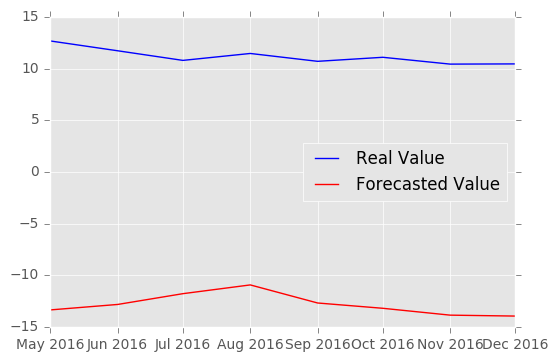

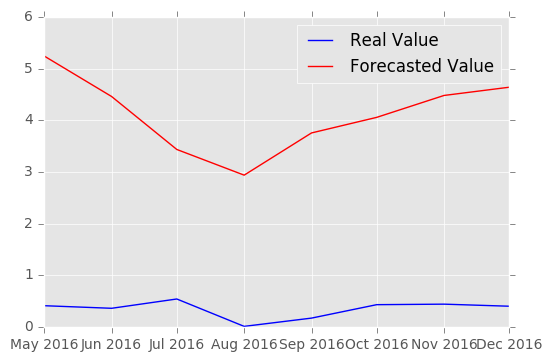

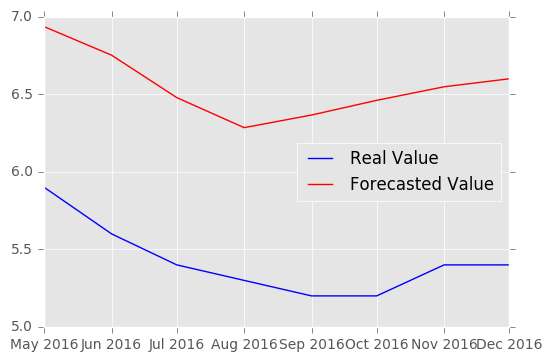

In [73]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])